# A class that implements the Moho inversion algorithm

This notebook presents a Python class that implements the proposed method. We'll use the [inverse problems framework](http://www.fatiando.org/api/inversion.html) of the library [Fatiando a Terra](http://www.fatiando.org). The class `MohoGravityInvSpherical` is defined in the [`moho.py`](moho.py) file.

## The Moho inversion method

Using the `fatiando.inversion` API. The inversion will be based on the method of Silva et al. 2014 to speedup computations. Silva et al. 2014 modify Bott's (1960) method. They show that Bott's method is a special case of the Gauss-Newton method

$$
\mathbf{p}^{k+1} 
= \mathbf{p}^k + \left[\mathbf{A}^T \mathbf{A}\right]^{-1} \mathbf{A}^T [\mathbf{d}^o - \mathbf{d}(\mathbf{p}^k)]
$$

but with the Jacobian $\mathbf{A}$ approximated by a diagonal with 

$$
A_{ii} = 2\pi G \rho
$$. 

Silva et al. also implement a step size modification algorithm similar to Marquardt's method to speed up convergence.
 
Silva et al. don't actually solve the Gauss-Newton iterations to avoid the linear systems. However, all matrices involved are (very) sparse. The `fatiando.inversion` package can handle `scipy.sparse` matrices transparently so we'll use the standard inversion classes with sparse matrices for our implementation.

The step size modification algorithm can then be substituted by the Levemberg-Marquardt algorithm because solving the sparse linear systems is trivial and very fast.

## Bott's method as a special case of the Steepest Descent method

We can further expand the method to cast Bott's method as a special case of the Steepest Descent algorithm. 
The step in the Steepest Descent method is

$$
\mathbf{p}^{k+1} 
= \mathbf{p}^k - \nabla \Theta(\mathbf{p}^k) 
= \mathbf{p}^k + 2\mathbf{A}^T \left[\mathbf{d}^o - \mathbf{d}(\mathbf{p}^k)\right]
$$

Bott's method would then be the special case of $\mathbf{A}$ being a diagonal matrix with 

$$
A_{ii} = \frac{1}{2(2 \pi G \rho_i)}.
$$

## Test the class on some simple synthetic data

In [2]:
%matplotlib inline
from __future__ import division
import numpy as np
import multiprocessing
import time
from IPython.display import Image
import matplotlib.pyplot as plt
from fatiando.vis import myv, mpl
from fatiando.gravmag import tesseroid
from fatiando import utils, gridder
import fatiando
from tesseroid_mesh import TesseroidRelief
from moho import MohoGravityInvSpherical

In [3]:
print(fatiando.__version__)

632c527ffcfe125cb7f906858a4ef474ec7f90ec


In [4]:
# Get the number of cores in the computer to run the forward modeling in parallel
ncpu = multiprocessing.cpu_count()
ncpu

4

In [5]:
shape = (30, 30)
# Make a regular grid inside an area
area = (-40, 40, 20, 60)
lon, lat, h = gridder.regular(area, shape, z=100e3)
# The model area is slightly larger because the points generated above are in the center of each cell.
dlon, dlat = gridder.spacing(area, shape)
modelarea = (area[0] - dlon/2, area[1] + dlon/2, area[2] - dlat/2, area[3] + dlat/2)
# Make a checkerboard relief undulating along the -35km height reference
f = 0.2
reference = -35e3
relief = 10e3*np.sin(f*lon)*np.cos(f*lat) + reference
# The density contrast is negative if the relief is below the reference
density = 600*np.ones_like(relief)
density[relief < reference] *= -1

In [6]:
model = TesseroidRelief(modelarea, shape, relief, reference, {'density': density})

In [7]:
def plot_result_3d(moho, fname):
    bounds = modelarea + (-20e3, -60e3)
    scale = (1, 1, 40) # Exaggerate the radial dimension
    datarange = np.abs([moho.props['density'].max(), moho.props['density'].min()]).max()
    scene = myv.figure(zdown=False)
    plot = myv.tesseroids(moho, 'density', scale=scale)
    plot.module_manager.scalar_lut_manager.show_legend = True
    plot.module_manager.scalar_lut_manager.lut_mode = 'RdYlBu'
    plot.module_manager.scalar_lut_manager.data_range = [-datarange, datarange]
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.minimum_size = np.array([1, 1])
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.position2 = np.array([ 0.13741855,  0.64385382])
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.position = np.array([ 0.03303258,  0.07342193])
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.maximum_size = np.array([100000, 100000])
    plot.module_manager.scalar_lut_manager.label_text_property.color = (0, 0, 0)
    plot.module_manager.scalar_lut_manager.title_text_property.color = (0, 0, 0)
    scene.scene.camera.position = [2252864.9143914036, -5202911.2574882135, 8495162.9722945951]
    scene.scene.camera.focal_point = [3135763.9476126051, 1056258.4985192744, 829277.18542720564]
    scene.scene.camera.view_angle = 30.0
    scene.scene.camera.view_up = [0.6164057832087273, 0.57367112225287575, 0.53939350563383837]
    scene.scene.camera.clipping_range = [783483.44437851617, 16078402.004277557]
    scene.scene.camera.compute_view_plane_normal()
    scene.scene.render()
    myv.savefig(fname)
    #myv.show()
    myv.mlab.close()
    return Image(filename=fname)    

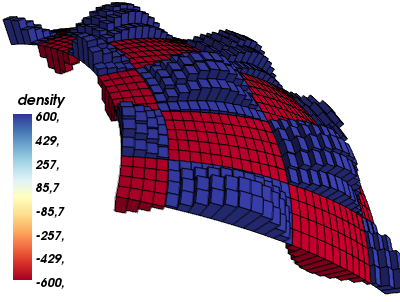

In [8]:
plot_result_3d(model, 'simple-synthetic-model.png')

For a sythetic test, I'll try to invert the sample mesh above from noise free data.

In [9]:
gz = tesseroid.gz(lon, lat, h, model, njobs=ncpu)

/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/matplotlib/tri/triangulation.py:110: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  self._neighbors)


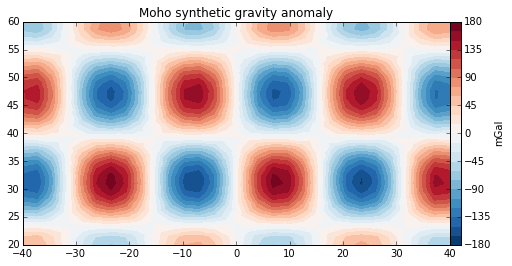

In [10]:
plt.figure(figsize=(9, 4))
plt.title('Moho synthetic gravity anomaly')
plt.tricontourf(lon, lat, gz, 30, cmap='RdBu_r')
plt.colorbar(pad=0).set_label('mGal')

First, configure the inversion:

Make a mesh.

In [11]:
mesh = model.copy(deep=True)
mesh.props['density'] = 600*np.ones(mesh.size)

Create the solver object.

In [12]:
solver = MohoGravityInvSpherical(lon, lat, h, gz, mesh, njobs=ncpu)

Configure the optimization method.

In [13]:
initial = np.ones(solver.nparams)*(mesh.reference - 30e3)
solver.config('newton', initial=initial, tol=0.2, maxit=10)

In [14]:
# Run the inversion and time the computation
%time solver.fit()

CPU times: user 53.5 ms, sys: 27.8 ms, total: 81.3 ms
Wall time: 8.73 s


/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/inversion/optimization.py:185: RuntimeWarning: Exited because maximum iterations reached. Might not have achieved convergence. Try inscreasing the maximum number of iterations allowed.
  RuntimeWarning)


Plot the RMS per iteration to get an idea of the convergence of the method.

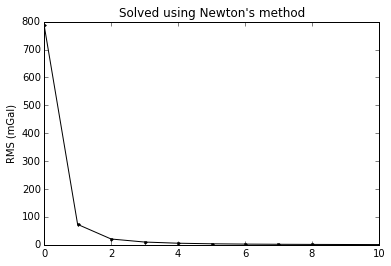

In [15]:
plt.figure()
ax1 = plt.subplot(111)
ax1.set_title('Solved using {}'.format(solver.stats_['method']))
rms = np.sqrt(solver.stats_['objective'])/np.sqrt(solver.ndata)
ax1.plot(rms, '.k-')
ax1.set_ylabel('RMS (mGal)')

Plot the data misfit and residuals

In [16]:
predicted = solver.predicted()
residuals = solver.residuals()
moho = solver.estimate_

/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


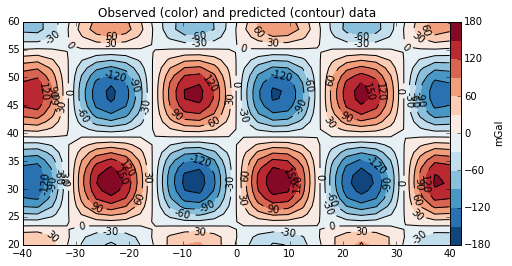

In [17]:
plt.figure(figsize=(9, 4))
levels = mpl.contourf(lon, lat, gz, shape, 12, cmap='RdBu_r')
plt.colorbar(pad=0).set_label('mGal')
mpl.contour(lon, lat, predicted, shape, levels)
plt.title('Observed (color) and predicted (contour) data')

Mean: 0.0552516883949   std: 0.845671086825


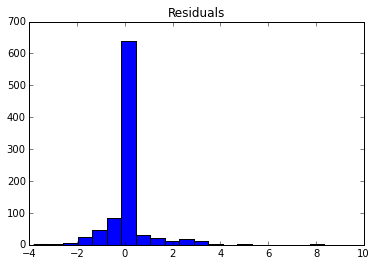

In [18]:
plt.title('Residuals')
plt.hist(residuals, bins=20)
print('Mean: {}   std: {}'.format(residuals.mean(), residuals.std()))

Map the estimated Moho depth.

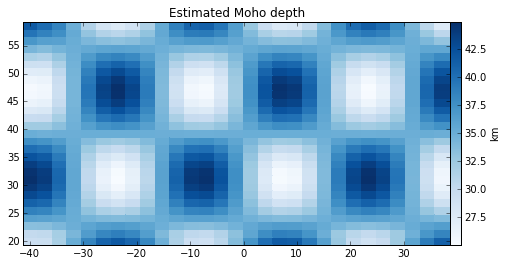

In [19]:
plt.figure(figsize=(9, 4))
plt.title("Estimated Moho depth")
mpl.pcolor(lon - dlon/2, lat - dlat/2, -0.001*moho.relief, shape, cmap='Blues')
plt.colorbar(pad=0).set_label('km')

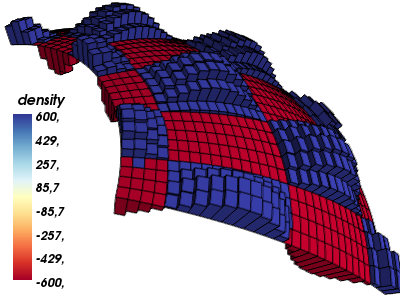

In [20]:
plot_result_3d(moho, 'mohoinv-example.png')

## Solve using Steepest Descent

In [21]:
solver.config('steepest', initial=initial, tol=0.2, maxit=10, linesearch=False)
%time solver.fit()

CPU times: user 28.8 ms, sys: 31.7 ms, total: 60.5 ms
Wall time: 8.15 s


/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/inversion/optimization.py:447: RuntimeWarning: Exited because maximum iterations reached. Might not have achieved convergence. Try inscreasing the maximum number of iterations allowed.
  RuntimeWarning)


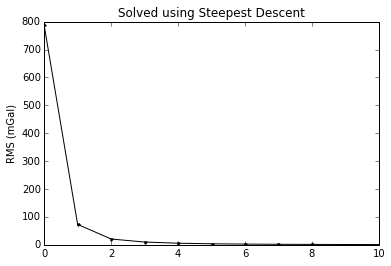

In [22]:
plt.figure()
ax1 = plt.subplot(111)
ax1.set_title('Solved using {}'.format(solver.stats_['method']))
rms = np.sqrt(solver.stats_['objective'])/np.sqrt(solver.ndata)
ax1.plot(rms, '.k-')
ax1.set_ylabel('RMS (mGal)')

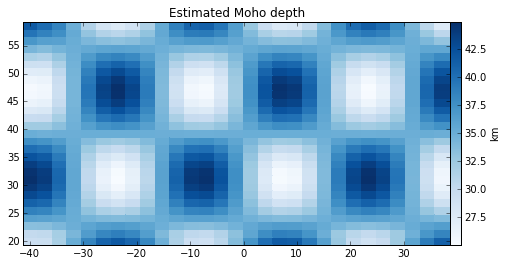

In [23]:
plt.figure(figsize=(9, 4))
plt.title("Estimated Moho depth")
mpl.pcolor(lon - dlon/2, lat - dlat/2, -0.001*solver.estimate_.relief, shape, cmap='Blues')
plt.colorbar(pad=0).set_label('km')

The computation time is roughly the same because solving the sparse systems is very cheap. So where does the code spend more time?

## Profile the inversion to see what is slow

I'll run the Python profiler (using the `%prun` IPython magic) to see where time is being spent in the inversion. I'll test the inversion by Gauss-Newton to see if solving the linear system has any impact on performance.

In [20]:
%prun -l 15 -q -T profiling.txt MohoGravityInvSpherical(lon, lat, h, gz, mesh).config('newton', initial=initial, tol=0.2).fit()
%cat profiling.txt

 
*** Profile printout saved to text file u'profiling.txt'. 
         2550169 function calls (2423355 primitive calls) in 32.924 seconds

   Ordered by: internal time
   List reduced from 1566 to 15 due to restriction <15>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       31   29.646    0.956   32.818    1.059 tesseroid.py:288(_forward_model)
    28092    0.209    0.000    0.496    0.000 context.py:139(resolve_data_type)
    27900    0.174    0.000    0.332    0.000 tesseroid_mesh.py:78(__getitem__)
     2685    0.160    0.000    0.161    0.000 values.py:86(__init__)
    28020    0.144    0.000    0.144    0.000 __init__.py:501(cast)
   455699    0.126    0.000    0.127    0.000 {isinstance}
        8    0.115    0.014    0.115    0.014 executionengine.py:93(finalize_object)
    27900    0.114    0.000    0.144    0.000 mesher.py:527(__init__)
        8    0.091    0.011    0.091    0.011 passmanagers.py:26(run)
    27923    0.077    0.000    0.606    0.00

So it seems that all of the time is spent on forward modeling. This is not a bad thing because we can easily parallelize the forward modeling. The current inversion class does this by keeping a process pool openned and running the forward modeling on it. Keeping the pool is necessary to minimize the overhead of forking the processes evey time `predicted` is called.

## Inverting a Moho with laterally varying density

Lets see if the method for a Moho with a varying density contrast between crust and mantle.

In [34]:
model_varied = model.copy(deep=True)
model_varied.props['density'].reshape(model.shape)[:12, -20:] *= 1.5

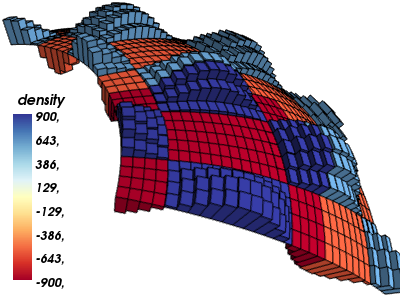

In [35]:
plot_result_3d(model_varied, 'moho-inv-example-vardens.png')

In [36]:
gz = tesseroid.gz(lon, lat, h, model_varied, njobs=ncpu)

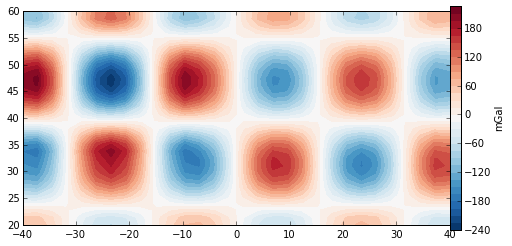

In [37]:
plt.figure(figsize=(9, 4))
plt.axis('scaled')
mpl.contourf(lon, lat, gz, shape, 40, cmap='RdBu_r')
plt.colorbar(pad=0).set_label('mGal')

In [38]:
mesh = model_varied.copy(deep=True)
vardens = MohoGravityInvSpherical(lon, lat, h, gz, mesh, njobs=ncpu)
vardens.config('newton', initial=initial, tol=0.2, maxit=10) 

In [39]:
%time vardens.fit()

CPU times: user 45.1 ms, sys: 28.2 ms, total: 73.3 ms
Wall time: 5.54 s


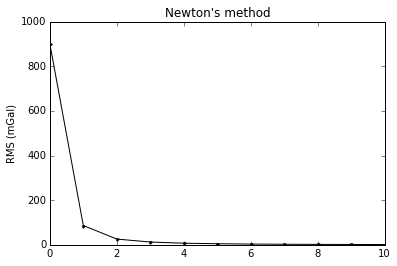

In [40]:
plt.figure()
ax1 = plt.subplot(111)
rms = np.sqrt(vardens.stats_['objective'])/np.sqrt(solver.ndata)
ax1.plot(rms, '.k-')
ax1.set_ylabel('RMS (mGal)')
ax1.set_title(vardens.stats_['method'])

In [41]:
predicted = vardens.predicted()
residuals = vardens.residuals()
moho = vardens.estimate_

Mean: 0.0628808557211   std: 1.21869458873


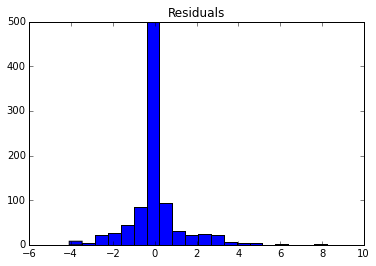

In [42]:
plt.title('Residuals')
plt.hist(residuals, bins=20)
print('Mean: {}   std: {}'.format(residuals.mean(), residuals.std()))

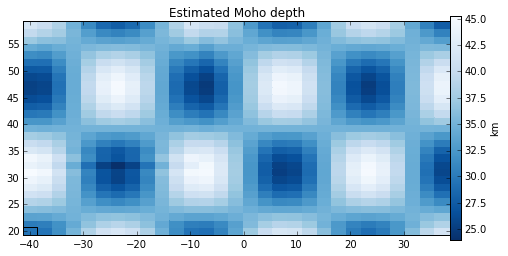

In [43]:
plt.figure(figsize=(9, 4))
plt.title("Estimated Moho depth")
plt.axis('scaled')
mpl.pcolor(lon - dlon/2, lat - dlat/2, -0.001*moho.relief, shape, cmap='Blues_r')
plt.colorbar(pad=0).set_label('km')
mpl.square(model[0].get_bounds()[:4])

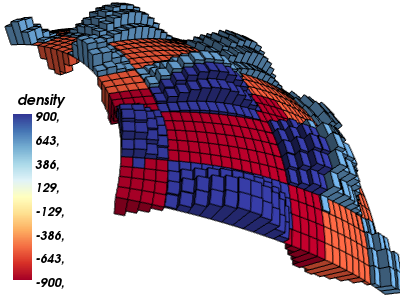

In [44]:
plot_result_3d(moho, 'moho-inv-example-vardens-result.png')